# <b>Introduction/Business Problem Section</b>

Today, '<b>Wine bar</b>' are very trendy in <b>Paris</b>. We would like to open our restaurant in the French capital, but some questions must be answered before reaching the final decision to open the store at a specific location in the city.

<ol type="1">
<li> What "Customer base" are we going to target ?
    <ul><li> Are we targeting the business people during the lunch break or during the evening ? </li></ul>
</li>
<li> Where is the "best place" to open it ?
    <ul><li> Some boroughs are more residential than others <br /> => For example the 14<sup>th</sup> and 16<sup>th</sup> boroughs are very residential. </li>
    <li> Some boroughs are more easier (administrative procedures) to open a new business <br /> => For example in the 11<sup>th</sup> borough, it is not possible anymore to open new bar. </li>
        <li> Are we near a Metro Station / Train ? </li></ul></li>
<li> What are the competitor restaurants ?
<ul>
    <li> How many wine bars have already opened their business by borough ? </li>
    <li> Are they working correclty ? </li>
    <li> What are the feedbacks given by the users ? (satisfaction level) </li></ul></li>
</ol>

All these stated questions can be alleviated by extracting relevant data. We will speak about it in the next section.

# <b>Data & Methodology Sections </b>

First of all we are going to extract the borough of Paris: https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris <br/>
As we can see the borough can be divided into several 'Quarters'. It will allow us to have an even more refined search.

In [1]:
import urllib3
import bs4 as BeautifulSoup
import requests

import pandas as pd
import numpy as np
import geocoder # To get latitude and longitude for our postal codes

from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from yellowbrick.cluster import KElbowVisualizer

import folium

from selenium import webdriver

In [2]:
# More easy to extract the postal codes from this website instead of the wiki page.
url = 'https://fr.geneawiki.com/index.php/Liste_des_quartiers_de_Paris'
http = urllib3.PoolManager()
response = http.request('GET', url)

soup = BeautifulSoup.BeautifulSoup(response.data)

/home/thomas/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


### Find the table which contains all postal codes related to Paris

In [3]:
tables = soup.findAll('table')

# The Paris Boroughs table is the 2nd table in the web page
postalcodes_table = tables[1]

In [4]:
rows = postalcodes_table.find_all('tr')

In [5]:
rows = postalcodes_table.find_all('tr')

headers = [] 
for cell in rows[0].find_all('td'):
    headers.append(cell.text.strip()) # remove \n
headers

['Code INSEE 1', 'Code Postal', 'Arrondissements', 'Quartiers']

In [6]:
# Translate headers in english and normalize it
headers[headers.index('Code INSEE 1')] = 'insee1_code'
headers[headers.index('Code Postal')] = 'postal_code'
headers[headers.index('Arrondissements')] = 'borough'
headers[headers.index('Quartiers')] = 'quarter'
headers

['insee1_code', 'postal_code', 'borough', 'quarter']

In [7]:
data = []
for row in rows[1:]: # Exclude headers line
    line = {}
    for cell_num, cell in enumerate(row.find_all('td')):
        cell = cell.text.strip()
        if cell_num <= 1: # Indexes 0 and 1
            line[headers[cell_num]] = cell 
        elif cell_num == 4:
            line['quarter'] = cell.split('\n')
        else: # indexes 2 and 3 -> Join these 2 values, for example: "I - Le Louvre"
            borough = headers[2]
            if borough not in line:
                line[borough] = []
            line[borough].append(cell)
    data.append(line)

In [8]:
paris_df = pd.DataFrame(data)
paris_df

,borough,insee1_code,postal_code,quarter
0,"[I, Le Louvre]",75101,75001,"[01 - Saint-Germain-l'Auxerrois, 02 - Les Hall..."
1,"[II, La Bourse]",75102,75002,"[05 - Gaillon, 06 - Vivienne, 07 - Le Mail, 08..."
2,"[III, Le Temple]",75103,75003,"[09 - Les Arts-et-Métiers, 10 - Les Enfants-Ro..."
3,"[IV, L'Hôtel-de-Ville]",75104,75004,"[13 - Saint-Merri, 14 - Saint-Gervais, 15 - L'..."
4,"[V, Le Panthéon]",75105,75005,"[17 - Saint-Victor, 18 - Le Jardin-des-Plantes..."
5,"[VI, Le Luxembourg]",75106,75006,"[21 - La Monnaie, 22 - L'Odéon, 23 - Notre-Dam..."
6,"[VII, Le Palais-Bourbon]",75107,75007,"[25 - Saint-Thomas-d'Aquin, 26 - Les Invalides..."
7,"[VIII, L'Élysée]",75108,75008,"[29 - Les Champs-Élysées, 30 - Le Faubourg-du-..."
8,"[IX, L'Opéra]",75109,75009,"[33 - Saint-Georges, 34 - La Chaussée-d'Antin,..."
9,"[X, L'Enclos-Saint-Laurent]",75110,75010,"[37 - Saint-Vincent-de-Paul, 38 - La Porte-Sai..."


# Formalize our dataframe

In [9]:
paris_df['borough'] = paris_df['borough'].str.join(' - ')

In [10]:
quarters_df_tmp = paris_df['quarter'].apply(pd.Series)

In [11]:
quarters_df = []
for col in quarters_df_tmp.columns:
    quarters_df.append(quarters_df_tmp[col])
quarters_df = pd.concat(quarters_df)

In [12]:
paris_df = pd.merge(paris_df, pd.DataFrame(quarters_df), left_index=True, right_index=True)
paris_df.drop('quarter', axis=1, inplace=True) # Not needed anymore. Replaced by next statement
paris_df.rename(columns={0: 'quarter'}, inplace=True)
paris_df.reset_index(drop=True, inplace=True)
paris_df.head(10)

,borough,insee1_code,postal_code,quarter
0,I - Le Louvre,75101,75001,01 - Saint-Germain-l'Auxerrois
1,I - Le Louvre,75101,75001,02 - Les Halles
2,I - Le Louvre,75101,75001,03 - Le Palais-Royal
3,I - Le Louvre,75101,75001,04 - La Place-Vendôme
4,II - La Bourse,75102,75002,05 - Gaillon
5,II - La Bourse,75102,75002,06 - Vivienne
6,II - La Bourse,75102,75002,07 - Le Mail
7,II - La Bourse,75102,75002,08 - Bonne-Nouvelle
8,III - Le Temple,75103,75003,09 - Les Arts-et-Métiers
9,III - Le Temple,75103,75003,10 - Les Enfants-Rouges


Now we would like to have the longitude and latitude of each quarter. This data is stored in each Wikipedia page of each quarter.<br />So, we are going to create a WebBrowser bot to find the interesting Wikipedia pages for us (regarding the quarters found previously). The coordinates of each quarter can be retrieved by extracting the value of the \<div\> attributes : 'data-lat' and 'data-lon'. 

In [13]:
# geocoder does not give us the coordinates of the quarters... .
# Let's scrap wikipedia to have the coordinates instead.

def coordinates_from(url):
    """
    Find the coordinates from the given URL
    """
    http = urllib3.PoolManager()
    response = http.request('GET', url)

    soup = BeautifulSoup.BeautifulSoup(response.data)

    latitude, longitude = 0, 0
    for div in soup.find_all('a'):
        if 'data-lat' in div.attrs:
            latitude, longitude = div['data-lat'], div['data-lon'] 
            break
    return latitude, longitude

In [14]:
quarters = []
for quarter in paris_df['quarter']:
    # Transform '01 - Saint-Germain-l'Auxerrois' -> 'Saint Germain l Auxerrois'
    quarters.append(quarter[5:].replace('-', ' ').replace('\'', ' '))

def find_best_url(a_tags, words_to_find):
    """
    Find the best url among the given tags: [<a href='url'>, ...]
    'words_to_find' list of words to found in the URL
    """
    for a_tag in a_tags:
        has_matched = True
        url_candidate = a_tag.get_attribute('href').lower()
        for word in words_to_find:
            if word.lower() not in url_candidate:
                has_matched = False
                break
        if has_matched:
            return a_tag.get_attribute('href') # All words have been found
    return '' # No URLs have satisfied the pre-requisites. Do not return any.

def url_from(query):
    """
    Find the URL (wiki page) based on the given query.
    For example:
    - query: Saint-Germain-l'Auxerrois
    - Will return: https://fr.wikipedia.org/wiki/Quartier_Saint-Germain-l%27Auxerrois
    We will find each wiki page for each quarter as it contains the coordinates of each quarter.
    """
    with webdriver.Firefox(executable_path=r'/home/thomas/geckodriver') as driver:
        # add 'wiki' and 'quartier' in the query to improve results
        driver.get('https://www.google.com/search?q=wiki quartier {}'.format(query))
        a_tags = driver.find_elements_by_partial_link_text('fr.wikipedia.org')
        try:
            return find_best_url(a_tags, ['wiki', 'quartier'])
        except IndexError:
            return ''

In [15]:
def find_url_quarters(paris_df):
    """
    Find the Wiki page of a given quarter
    """
    wiki_quarter_urls = {}
    for quarter_name, quarter_normalized in zip(paris_df['quarter'], quarters):
        quarter_url = url_from(quarter_normalized)
        print('{}: {}'.format(quarter_name, quarter_url))
        wiki_quarter_urls[quarter_name] = (quarter_url)
    return wiki_quarter_urls

#wiki_quarter_urls = find_url_quarters(paris_df)

In [16]:
# Let's add the coordinates into our DataFrame
paris_df['latitude'] = np.nan
paris_df['longitude'] = np.nan

def set_quarter_location(wiki_quarter_urls, paris_df):
    """
    Once we have the Quarter wiki page, we can fill the GPS location of it.
    The GPS location on the Wiki page are standardized (same location in the wiki page)
    """
    for quarter_idx, wiki_quarter_url in enumerate(wiki_quarter_urls):
        latitude, longitude = coordinates_from(wiki_quarter_urls[wiki_quarter_url])
        paris_df.loc[quarter_idx, 'latitude'] = float(latitude)
        paris_df.loc[quarter_idx, 'longitude'] = float(longitude)
    return paris_df

#paris_df = set_quarter_location(wiki_quarter_urls, paris_df)

In [17]:
# Let's save it to avoid to do same process later
#paris_df.to_csv('paris_df.csv', index=False)

In [18]:
paris_df = pd.read_csv('paris_df.csv')

In [19]:
paris_df.head(10)

,borough,insee1_code,postal_code,quarter,latitude,longitude
0,I - Le Louvre,75101,75001,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195
1,I - Le Louvre,75101,75001,02 - Les Halles,48.862541,2.344744
2,I - Le Louvre,75101,75001,03 - Le Palais-Royal,48.864912,2.337749
3,I - Le Louvre,75101,75001,04 - La Place-Vendôme,48.867495,2.329402
4,II - La Bourse,75102,75002,05 - Gaillon,48.869083,2.332867
5,II - La Bourse,75102,75002,06 - Vivienne,48.869069,2.339176
6,II - La Bourse,75102,75002,07 - Le Mail,48.867982,2.344615
7,II - La Bourse,75102,75002,08 - Bonne-Nouvelle,48.866776,2.350087
8,III - Le Temple,75103,75003,09 - Les Arts-et-Métiers,48.866253,2.356846
9,III - Le Temple,75103,75003,10 - Les Enfants-Rouges,48.864729,2.363155


In [20]:
CLIENT_ID = 'JGLKPNP2TKS5' # your Foursquare ID
CLIENT_SECRET = '5IICU3MT1QAS4FQQKUYNKZG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# Explore locations using Foursquare API

In [23]:
def getNearbyQuarter(names, latitudes, longitudes, radius=500, LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    columns = ['quarter', 'quarter_latitude', 'quarter_longitude', 
              'interest_point', 'interest_point_latitude', 'interest_point_longitude', 'interest_point_type']
    data = [item for venue_list in venues_list for item in venue_list]
    
    return pd.DataFrame(data=data, columns=columns)

In [21]:
#paris_interest_points = getNearbyQuarter(paris_df['quarter'], latitudes=paris_df['latitude'], longitudes=paris_df['longitude'])
#paris_interest_points.to_csv('paris_interest_points.csv', index=False)

In [22]:
# Avoid to fetch several times the Foursquare API (as the calls to the API are limited per day).
paris_interest_points = pd.read_csv('paris_interest_points.csv')
paris_interest_points.head(10)

,quarter,quarter_latitude,quarter_longitude,interest_point,interest_point_latitude,interest_point_longitude,interest_point_type
0,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza
1,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Place du Louvre,48.859841,2.340822,Plaza
2,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
3,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Le Fumoir,48.860424,2.340868,Cocktail Bar
4,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Église Saint-Germain-l'Auxerrois (Église Saint...,48.859520,2.341306,Church
5,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,La Régalade Saint-Honoré,48.861620,2.341749,French Restaurant
6,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Pont des Arts,48.858565,2.337635,Bridge
7,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Pret A Manger,48.861811,2.341311,Sandwich Place
8,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Coffee Crêpes,48.858841,2.340802,Coffee Shop
9,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,Boutique yam'Tcha,48.861710,2.342380,Chinese Restaurant


In [23]:
paris_interest_points.shape

(5606, 7)

We have extracted 5606 'interesting points' (which can be shops / restaurant / historical monuments, ...). <br/>
This is not a very large sample but we will try to exploit and find cluster into this dataset

<b>Summary of the data extracted</b>: This dataset will help us to visualize the distribution of the different shops in the City. Like that, we can avoid to open our store next to another Wine bar.<br /> Also It will give us an overview of the 'attractive' location position (for example: 'Pont des Arts' which is located here: 48.858565, 2.337635) which will make a place more attractive

We have now extracted our dataset from Foursquare in order to analyze the restaurants distribution in Paris. <br />
There is also another website which can be really interesting in order to add other data to our current dataset which is :
    https://opendata.paris.fr/pages/home/

# "Interest Point" Types per Quarters

In [24]:
paris_onehot = pd.get_dummies(paris_interest_points[['interest_point_type']], prefix="", prefix_sep="")

# add quarter column back to dataframe
paris_onehot['quarter'] = paris_interest_points['quarter'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,quarter,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,01 - Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01 - Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,01 - Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,01 - Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01 - Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Get Ratio of "Interest Point" Type per Quarter 

In [25]:
paris_grouped = paris_onehot.groupby('quarter').mean().reset_index()
paris_grouped.head(10)

,quarter,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,01 - Saint-Germain-l'Auxerrois,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.030612,0.00,0.00,0.00,0.0,0.0
1,02 - Les Halles,0.00,0.0,0.02,0.0,0.01,0.00,0.00,0.0,0.00,...,0.0,0.0,0.01,0.0,0.040000,0.00,0.01,0.00,0.0,0.0
2,03 - Le Palais-Royal,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.01,0.0,0.030000,0.01,0.00,0.00,0.0,0.0
3,04 - La Place-Vendôme,0.02,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.00,0.0,0.010000,0.01,0.01,0.00,0.0,0.0
4,05 - Gaillon,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.02,0.0,0.000000,0.01,0.01,0.00,0.0,0.0
5,06 - Vivienne,0.00,0.0,0.00,0.0,0.01,0.00,0.01,0.0,0.00,...,0.0,0.0,0.03,0.0,0.030000,0.01,0.01,0.00,0.0,0.0
6,07 - Le Mail,0.00,0.0,0.00,0.0,0.00,0.01,0.00,0.0,0.00,...,0.0,0.0,0.02,0.0,0.040000,0.00,0.02,0.00,0.0,0.0
7,08 - Bonne-Nouvelle,0.00,0.0,0.01,0.0,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.01,0.0,0.070000,0.00,0.01,0.00,0.0,0.0
8,09 - Les Arts-et-Métiers,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.01,...,0.0,0.0,0.04,0.0,0.040000,0.00,0.00,0.00,0.0,0.0
9,10 - Les Enfants-Rouges,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.02,...,0.0,0.0,0.03,0.0,0.070000,0.01,0.00,0.01,0.0,0.0


# Find the most common shops per Quarter

In [26]:
quarter_freqs = {}
n_most_common_shops = 5
for quarter_name in paris_grouped['quarter']:
    # Create a new dataframe from our row
    quarter_freq = paris_grouped[paris_grouped['quarter'] == quarter_name].T.reset_index()
    quarter_freq.columns = ['interest_point', 'freq']

    # Remove the quarter row from our new dataframe
    quarter_freq = quarter_freq[quarter_freq['interest_point']!='quarter']

    # Transform column to float to sort values
    quarter_freq['freq'] = quarter_freq['freq'].astype(float)
    quarter_freq['freq'] = quarter_freq['freq'] * 100
    quarter_freq = quarter_freq.round({'freq': 2})
    quarter_freq.sort_values('freq', ascending=False, inplace=True)
    quarter_freqs[quarter_name] = quarter_freq.iloc[:5, 0].tolist()

In [27]:
for quarter_freq in quarter_freqs:
    print(quarter_freq, end='\n')
    print(' => ', ' / '.join(quarter_freqs[quarter_freq]), end='\n')
    print()

01 - Saint-Germain-l'Auxerrois
 =>  French Restaurant / Hotel / Café / Bar / Plaza

02 - Les Halles
 =>  French Restaurant / Bakery / Café / Wine Bar / Bar

03 - Le Palais-Royal
 =>  Japanese Restaurant / French Restaurant / Hotel / Café / Coffee Shop

04 - La Place-Vendôme
 =>  Hotel / French Restaurant / Japanese Restaurant / Boutique / Chocolate Shop

05 - Gaillon
 =>  Hotel / Japanese Restaurant / French Restaurant / Italian Restaurant / Jewelry Store

06 - Vivienne
 =>  French Restaurant / Japanese Restaurant / Bistro / Italian Restaurant / Café

07 - Le Mail
 =>  Cocktail Bar / French Restaurant / Bakery / Italian Restaurant / Wine Bar

08 - Bonne-Nouvelle
 =>  Cocktail Bar / Wine Bar / French Restaurant / Bakery / Hotel

09 - Les Arts-et-Métiers
 =>  French Restaurant / Hotel / Italian Restaurant / Bar / Cocktail Bar

10 - Les Enfants-Rouges
 =>  Wine Bar / Bistro / French Restaurant / Hotel / Cocktail Bar

11 - Les Archives
 =>  French Restaurant / Clothing Store / Pastry Shop 

In [28]:
def most_common_interest_points(row, num_top_interest_points):
    row_types = row.iloc[1:]
    row_types_sorted = row_types.sort_values(ascending=False)
    
    return row_types_sorted.index.values[0:num_top_interest_points]

In [29]:
num_top_interest_points = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['quarter']
for ind in range(num_top_interest_points):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quarter_interest_point_sorted = pd.DataFrame(columns=columns)
quarter_interest_point_sorted['quarter'] = paris_grouped['quarter']

for ind in range(paris_grouped.shape[0]):
    quarter_interest_point_sorted.iloc[ind, 1:] = most_common_interest_points(paris_grouped.iloc[ind, :], num_top_interest_points)

paris_grouped_clustering = paris_grouped.drop('quarter', axis=1)

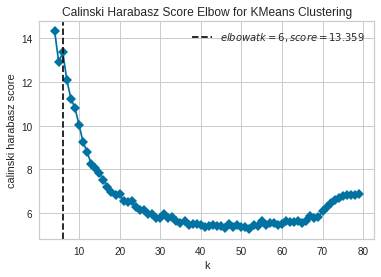

In [33]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,80), metric='calinski_harabasz', timings=False
)

visualizer.fit(paris_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The "Elbow" method is used to find the best number of clusters (k) for a given data model. In our case, this best 'k' is 6 as shown above.

In [30]:
# We have found previously (using the elbow method) that the best candidate 'N' is 6
kclusters = 6

# run k-means clustering on the best 'N'
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# add clustering labels
quarter_interest_point_sorted.insert(0, 'cluster_labels', kmeans.labels_)

paris_merged = paris_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(quarter_interest_point_sorted.set_index('quarter'), on='quarter')

# Some neighborhoods do not have any most common venues. Let's remove them. Also as their Cluster Labels is NaN, the column have been converted to float.
# Let's put it back to int
paris_merged = paris_merged[~paris_merged['cluster_labels'].isnull()]
paris_merged['Cluster Labels'] = paris_merged['cluster_labels'].astype(int)

paris_merged.head() # check the last columns!

,borough,insee1_code,postal_code,quarter,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,I - Le Louvre,75101,75001,01 - Saint-Germain-l'Auxerrois,48.860112,2.340195,1,French Restaurant,Café,Hotel,Plaza,Bar,Pizza Place,Bakery,Clothing Store,Wine Bar,Museum,1
1,I - Le Louvre,75101,75001,02 - Les Halles,48.862541,2.344744,1,French Restaurant,Bakery,Wine Bar,Café,Bar,Italian Restaurant,Hotel,Clothing Store,Pizza Place,Breakfast Spot,1
2,I - Le Louvre,75101,75001,03 - Le Palais-Royal,48.864912,2.337749,3,Japanese Restaurant,French Restaurant,Hotel,Café,Coffee Shop,Plaza,Ramen Restaurant,Udon Restaurant,Bar,Restaurant,3
3,I - Le Louvre,75101,75001,04 - La Place-Vendôme,48.867495,2.329402,2,Hotel,French Restaurant,Japanese Restaurant,Boutique,Chocolate Shop,Hotel Bar,Pastry Shop,Jewelry Store,Tea Room,Cocktail Bar,2
4,II - La Bourse,75102,75002,05 - Gaillon,48.869083,2.332867,3,Hotel,Japanese Restaurant,French Restaurant,Italian Restaurant,Bakery,Sandwich Place,Coffee Shop,Jewelry Store,Restaurant,Plaza,3


In [35]:
# Center map on Paris
longitude = 2.333333
latitude = 48.866667

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['latitude'], paris_merged['longitude'], paris_merged['quarter'], paris_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

# Display the "Most common" venues for each cluster

In [31]:
for cluster_num in range(0, kclusters):
    cluster = paris_merged.loc[paris_merged['cluster_labels'] == cluster_num, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
    most_common_venues = cluster.groupby('1st Most Common Venue')['1st Most Common Venue'].count().sort_values(ascending=False).index
    print('Most common venues for Cluster {}: {}'.format(cluster_num, ', '.join(most_common_venues)))

Most common venues for Cluster 0: French Restaurant, Bar
Most common venues for Cluster 1: French Restaurant
Most common venues for Cluster 2: Hotel, French Restaurant
Most common venues for Cluster 3: French Restaurant, Bar, Hotel, Japanese Restaurant, Cocktail Bar, Bakery, Wine Bar, Supermarket, Coffee Shop, Bus Stop
Most common venues for Cluster 4: Nightclub
Most common venues for Cluster 5: Racecourse


# Results & Discussion

First of all, we can see that Paris is very focused on "Restaurants". "French" gastronomy encapsulates a large amount of specialities from all over France. For example, you can have Lyon Specialities (Brioche-style sausage, ...) or the "Breton crepe", the Cassoulet of Toulouse, etc... . <br/> So, if we are going to open a Wine bar which can be assimilated by some as a "Restaurant", we must focus on clusters were "Restaurants" are not very present. 
The advantages to open a Wine bar into these clusters without restaurants are:
- to have less competitors
- to retain new customers who are not already 'accustomed' customers to nearby restaurants

So, now we will check clusters without restaurants (which are clusters 4 and 5).

In [32]:
paris_merged[paris_merged['cluster_labels'].isin([4,5])]

,borough,insee1_code,postal_code,quarter,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
60,XVI - Passy,75116,75016,61 - Auteuil,48.852235,2.252798,4,Nightclub,Restaurant,Outdoors & Recreation,Racecourse,Nature Preserve,Plaza,Circus,Falafel Restaurant,Ethiopian Restaurant,Event Space,4
61,XVI - Passy,75116,75016,62 - La Muette,48.853139,2.257004,5,Racecourse,Circus,Zoo Exhibit,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,5


In [37]:
paris_interest_points[(paris_interest_points['quarter'].isin(['61 - Auteuil', '62 - La Muette']))]

,quarter,quarter_latitude,quarter_longitude,interest_point,interest_point_latitude,interest_point_longitude,interest_point_type
4706,61 - Auteuil,48.852235,2.252798,Hippodrome d'Auteuil,48.851933,2.256789,Racecourse
4707,61 - Auteuil,48.852235,2.252798,Jockey Disque,48.853783,2.255724,Nightclub
4708,61 - Auteuil,48.852235,2.252798,Le Petit Jean Bouin,48.849923,2.250572,Outdoors & Recreation
4709,61 - Auteuil,48.852235,2.252798,"Bel Ami, Paris",48.854830,2.255355,Restaurant
4710,61 - Auteuil,48.852235,2.252798,Wizard Trees,48.854492,2.249035,Nature Preserve
4711,61 - Auteuil,48.852235,2.252798,Cirque de Noël Christiane Bouglione,48.855720,2.254768,Circus
4712,61 - Auteuil,48.852235,2.252798,Porte de St Cloud,48.851416,2.259043,Plaza
4713,62 - La Muette,48.853139,2.257004,Hippodrome d'Auteuil,48.851933,2.256789,Racecourse
4714,62 - La Muette,48.853139,2.257004,Cirque Alexis Gruss,48.857376,2.254971,Circus


We can see that there are some different type of "venues" in these 2 quarters which can attract people. As said before the data sample is not quite big and some important "venues" are not listed by Foursquare API (For example there are lot of museum in the 16th borough).

# Conclusion
We can see that the best place to open our new Wine bar is the 16th borough of Paris and particularly in the "62 - La Muette" quarter (as the 2nd most common venue for the "61 -Auteuil" quarter is "Restaurant" category). <br/>As shown previously there are lot of different venues "type" in this borough which can attract different type of people and also these 2 quarters are residential. So, there are people at any time of the day (unkike some boroughs which are mainly composed of offices so there are less people in the evening.  